#### 7.1 From Fully Connected Layers to Convolutions

In [1]:
pip install d2l

#### 7.1.1 Invariance
#### 7.1.2 Constraining the MLP

$$\begin{aligned} \left[\mathbf{H}\right]_{i, j} &= [\mathbf{U}]_{i, j} + \sum_k \sum_l[\mathsf{W}]_{i, j, k, l}  [\mathbf{X}]_{k, l}\\ &=  [\mathbf{U}]_{i, j} +
\sum_a \sum_b [\mathsf{V}]_{i, j, a, b}  [\mathbf{X}]_{i+a, j+b}.\end{aligned}$$


$$\begin{aligned} \left[\mathbf{H}\right]_{i, j} &= [\mathbf{U}]_{i, j} + \sum_k \sum_l[\mathsf{W}]_{i, j, k, l}  [\mathbf{X}]_{k, l}\\ &=  [\mathbf{U}]_{i, j} +
\sum_a \sum_b [\mathsf{V}]_{i, j, a, b}  [\mathbf{X}]_{i+a, j+b}.\end{aligned}$$
#### 7.1.2.2 Locality
As motivated above, we believe that we should not have
to look very far away from location $(i, j)$
in order to glean relevant information
to assess what is going on at $[\mathbf{H}]_{i, j}$.

$$[\mathbf{H}]_{i, j} = u + \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} [\mathbf{V}]_{a, b}  [\mathbf{X}]_{i+a, j+b}.$$
:eqlabel:`eq_conv-layer`

#### 7.1.3 Convolutions

$$(f * g)(\mathbf{x}) = \int f(\mathbf{z}) g(\mathbf{x}-\mathbf{z}) d\mathbf{z}.$$
That is, we measure the overlap between $f$ and $g$
when one function is "flipped" and shifted by $\mathbf{x}$.

#### 7.1.4 Channels
$$[\mathsf{H}]_{i,j,d} = \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} \sum_c [\mathsf{V}]_{a, b, c, d} [\mathsf{X}]_{i+a, j+b, c},$$
:eqlabel:`eq_conv-layer-channels`

where $d$ indexes the output channels in the hidden representations $\mathsf{H}$. The subsequent convolutional layer will go on to take a third-order tensor, $\mathsf{H}$, as input.

#### 7.1.5 Summary and Discussion
Adding channels allowed us to bring back some of the complexity that was lost due to the restrictions imposed on the convolutional kernel by locality and translation invariance.


### 7.2 Convolutions for images

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

#### 7.2.1. The Cross-Correlation Operation¶

In [ ]:
def corr2d(X, K):
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

#### 7.2.2 Convolutional Layers

In [ ]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In [ ]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [ ]:
K = torch.tensor([[1.0, -1.0]])

In [ ]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [ ]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

#### 7.2.4 Learning a Kernel

In [ ]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # Learning rate

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 15.792
epoch 4, loss 4.758
epoch 6, loss 1.662
epoch 8, loss 0.633
epoch 10, loss 0.251


In [ ]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9350, -1.0373]])

#### 7.2.5 Cross-Correlation and Convolution
It is noteworthy that since kernels are learned from data in deep learning, the outputs of convolutional layers remain unaffected no matter such layers perform either the strict convolution operations or the cross-correlation operations.

#### 7.2.6 Feature Map and Receptive Field

#### 7.2.7 Summary
The core computation required for a convolutional layer is a cross-correlation operation. We saw that a simple nested for-loop is all that is required to compute its value. If we have multiple input and multiple output channels, we are performing a matrix–matrix operation between channels.


#### 7.2.8 Exercise
## 대각선 에지가 있는 이미지 X 구성:

- 이미지 X를  2D 행렬로 표현 대각선 에지는 행렬의 대각선이 높은 1, 나머지는 0
다음과 같이 간단한 \(3 \times 3\) 행렬 생성

X =
\[
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 \\
\end{bmatrix}
\]

여기서 값 1은 강도가 높은 부분(대각선)을, 값 0은 강도가 낮은 부분

## 커널 K를 이미지 X에 적용:

K =
\[
\begin{bmatrix}
0 & 1 & 0 \\
1 & -4 & 1 \\
0 & 1 & 0 \\
\end{bmatrix}
\]

이 커널은 이미지의 에지를 강조하는 데 사용,
X에 적용하면 X의 대각선 에지가 강조됨

## X의 전치행렬 (Transpose of X):

X^T =
\[
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 \\
\end{bmatrix}
\]

대각선이 동일하므로, X의 전치행렬은 원래 행렬과 동일
따라서 X를 전치해도 커널을 적용한 결과는 변화없음.

## K의 전치행렬 (Transpose of K):

커널 K의 전치행렬 \(K^T\):

K^T =
\[
\begin{bmatrix}
0 & 1 & 0 \\
1 & -4 & 1 \\
0 & 1 & 0 \\
\end{bmatrix}
\]

커널 K는 대칭적이므로, K를 전치해도 결과는 동일하게 유지됩니다. 따라서 K를 전치해도 X에 적용한 결과에 변화가 없음

## 결론:

- 커널 K를 대각선 에지가 있는 이미지 X에 적용하면 에지가 강조
- X를 전치해도 결과는 변하지 않음
- K를 전치해도 결과는 변하지 않음


### 7.3 Padding and Stride


In [ ]:
import torch
from torch import nn

#### 7.3.1 Padding

In [ ]:
# We define a helper function to calculate convolutions. It initializes the
# convolutional layer weights and performs corresponding dimensionality
# elevations and reductions on the input and output
def comp_conv2d(conv2d, X):
    # (1, 1) indicates that batch size and the number of channels are both 1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Strip the first two dimensions: examples and channels
    return Y.reshape(Y.shape[2:])

# 1 row and column is padded on either side, so a total of 2 rows or columns
# are added
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [ ]:
# We use a convolution kernel with height 5 and width 3. The padding on either
# side of the height and width are 2 and 1, respectively
conv2d = nn.LazyConv2d(1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

####7.3.2 Stride

In [ ]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [ ]:
conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

#### 7.3.3 Summary and Discussion

adding can increase the height and width of the output. This is often used to give the output the same height and width as the input to avoid undesirable shrinkage of the output. Moreover, it ensures that all pixels are used equally frequently. Typically we pick symmetric padding on both sides of the input height and width.

**미러패딩**
- 텐서의 경계값을 그대로 반사시켜서 텐서를 확장하는 패딩 방법


In [ ]:
import torch.nn.functional as F

def mirror_padding(tensor, pad_size):
    # tensor: 입력 텐서
    # pad_size: 각 축에 대해 패딩할 크기 (좌우 또는 상하)

    # F.pad 함수를 사용하여 텐서의 끝값을 반사시키는 패딩을 적용
    padded_tensor = F.pad(tensor, (pad_size, pad_size), mode='reflect')

    return padded_tensor

# 예시
x = torch.tensor([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]], dtype=torch.float32)

# 각 축에 대해 1만큼 미러 패딩 적용
padded_x = mirror_padding(x, 1)

print(padded_x)

tensor([[2., 1., 2., 3., 2.],
        [5., 4., 5., 6., 5.],
        [8., 7., 8., 9., 8.]])


###7.4 Multiple Input and Multiple Output Channels


In [ ]:
import torch
from d2l import torch as d2l

#### 7.4.1 Multiple Input Channels

In [ ]:
def corr2d_multi_in(X, K):
    # Iterate through the 0th dimension (channel) of K first, then add them up
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [ ]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

#### 7.4.2 Multiple Output Channels

In [ ]:
def corr2d_multi_in_out(X, K):
    # Iterate through the 0th dimension of K, and each time, perform
    # cross-correlation operations with input X. All of the results are
    # stacked together
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [ ]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [ ]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

#### 7.4.3 1X1 Convolutional Layer

In [ ]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # Matrix multiplication in the fully connected layer
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

In [ ]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

### 7.5 Pooling


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

#### 7.5.1 Maximum Pooling and Average Pooling

In [ ]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [ ]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

#### 7.5.2 Padding and Stride

In [ ]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [ ]:
pool2d = nn.MaxPool2d(3)
# Pooling has no model parameters, hence it needs no initialization
pool2d(X)

tensor([[[[10.]]]])

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [ ]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

#### 7.5.3 Multiple Channels

In [ ]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

### 7.6 Convolutional Neural Networks(LeNet)

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

#### 7.6.1 LeNet

In [ ]:
def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

In [ ]:
@d2l.add_to_class(d2l.Classifier)
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


#### 7.6.2 Training

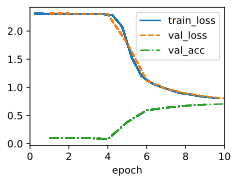

In [ ]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

### 8.2 Networks Using Blocks

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

#### 8.2.1 VGG Blocks

In [3]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

#### 8.2.2 VGG Network

In [4]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [5]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary(
    (1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


#### 8.2.3 Training

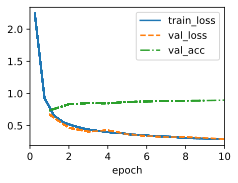

In [6]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

#### 8.2.4 Summary & Discussion
- VGG vs Alexnet

**AlexNet**
- 비교적 얕은 네트워크 수로, 주로 5개의 합성곱(convolutional) 레이어와 Fully connected 레이어로 구성되어있음
- 파라미터 수는 60만개
**VGG**
- 16 또는 19개의 합성곱 레이어로 깊고, 각 레이어의 필터 크기는 작다
- VGG-16은 138만개의 파라미터를 가지고 있고, AlexNet보다 더 많다

** Fully Connected Layer** : 모든 입력 노드가 출력 노드와 연결되어서 연산량이 매우 많음
- AlexNEt은 주로 Fully connected layer에서 많은 파라미터와 연산이 발생함
- VGG에서도 상당부분을 차지하지만, 합성곱 층의 연산량이 더 많아서 VGG의 비율은 낮다

** Fully Connected Layer의 연산량을 줄이는 방법**
1. 크기 축소 : Fully connected layer의 뉴런 수를 줄여서 연산량과 메모리 사용량을 크게 줄임
2. Dropout : 일부 뉴런들을 랜덤으로 제외시켜서 연산량을 줄이고 오버피팅을 방지하는 방법

### 8.2 Residual Networks and ResNet

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

#### 8.6.1 Function Classes

#### 8.6.2 Function Classes

In [ ]:
class Residual(nn.Module):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [ ]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

torch.Size([4, 3, 6, 6])

In [ ]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

#### 8.6.3 ResNet Model

In [ ]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [ ]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [ ]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


#### 8.6.4 Training

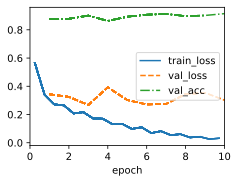

In [ ]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)